In [18]:
import pandas as pd
import numpy as np
# import tensorflow as tf
import sklearn

import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# import tensorflow_decision_forests as tfdf

import tqdm
import re

In [2]:
df = pd.read_csv('answerList_data.csv')

def calculate_ttr(text):
    words = str(text).split()
    unique = set(words)
    ttr = len(unique) / len(words)
    return ttr

df['complexity'] = df['Answer.explanation'].apply(calculate_ttr)

In [3]:
students = ['Undergraduate_Student', 'Graduate_Student']
students_df = df[df['Worker.profession'].isin(students)]
others_df = df[~df['Worker.profession'].isin(students)]

students_df_gt = students_df[students_df['GroundTruth'] == 1]
students_df_ngt = students_df[students_df['GroundTruth'] == 0]

students_df_gt_train, students_df_gt_test = sklearn.model_selection.train_test_split(students_df_gt, test_size=0.2)
students_df_ngt_train, students_df_ngt_test = sklearn.model_selection.train_test_split(students_df_ngt, test_size=0.2)

students_df_train = pd.concat([students_df_gt_train, students_df_ngt_train], ignore_index=True).drop(columns=['TN', 'FN', 'TP', 'FP'])
students_df_test = pd.concat([students_df_gt_test, students_df_ngt_test], ignore_index=True).drop(columns=['TN', 'FN', 'TP', 'FP'])


In [45]:
label = "GroundTruth"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_df_train, label=label)
holdout_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_df_test, label=label)
complete_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_df, label=label)

In [46]:
tuner = tfdf.tuner.RandomSearch(num_trials=30, use_predefined_hps=True)
model_1 = tfdf.keras.RandomForestModel(tuner=tuner)


model_1.fit(train_ds, verbose=2)

Use /var/folders/36/2qtcl0jx6r94h6345h20r6880000gn/T/tmpc2ualy2t as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 

In [47]:
model_1.compile(metrics=['Precision', 'Recall'])
evaluation = model_1.evaluate(holdout_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 468ms/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 0.4516

loss: 0.0000
precision: 1.0000
recall: 0.4516


In [48]:
predictions = model_1.predict(holdout_ds, verbose=2)

1/1 - 0s - 85ms/epoch - 85ms/step


In [49]:
students_df_test_eval = students_df_test.copy()
students_df_test_eval['Prediction'] = predictions
students_df_test_eval['PredictionRounded'] = predictions
students_df_test_eval.PredictionRounded = students_df_test_eval.PredictionRounded.round()
students_df_test_eval['RightPrediction'] = np.where(students_df_test_eval['PredictionRounded'] == students_df_test_eval['GroundTruth'], True, False)
students_df_test_eval['ExplanationLength'] = students_df_test_eval['Answer.explanation'].str.len()


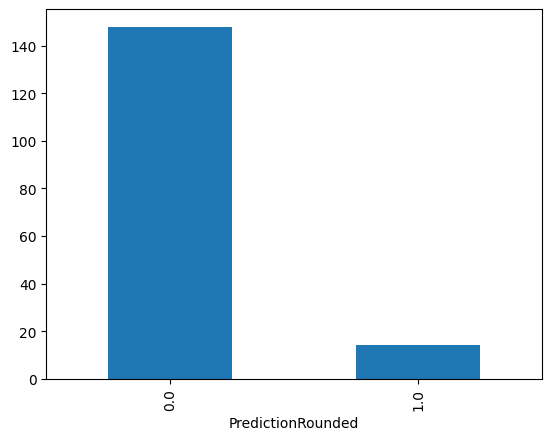

In [50]:
plot_3 = students_df_test_eval['PredictionRounded'].value_counts().plot(kind='bar')

In [51]:
holdout_df = students_df_test.copy()
others_df_shuffled = sklearn.utils.shuffle(others_df).drop(columns=['TP', 'TN', 'FP', 'FN'])

set_size = 10
evaluations = []

model_1.compile(metrics=['Precision', 'Recall'])

for i in range(1, 150):
    holdout_df = students_df_test.copy()
    holdout_df = pd.concat([holdout_df, others_df_shuffled.iloc[0:i*set_size]])
    ds = tfdf.keras.pd_dataframe_to_tf_dataset(holdout_df, label=label)
    evaluations.append(model_1.evaluate(ds, return_dict=True))

2/2 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 0.5110


In [52]:
print(evaluations)

[{'loss': 0.0, 'precision': 1.0, 'recall': 0.46875}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5142857432365417}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5142857432365417}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5277777910232544}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5526315569877625}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5365853905677795}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5365853905677795}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5348837375640869}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5333333611488342}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.54347825050354}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5531914830207825}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5306122303009033}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.529411792755127}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.529411792755127}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.529411792755127}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5094339847564697}, {'loss'

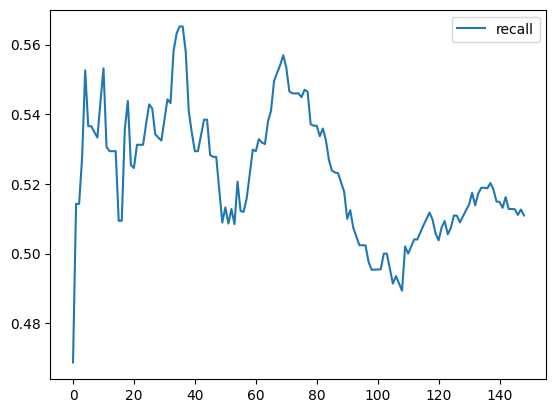

In [55]:
eval_df = df.from_records(evaluations)
plot_1 = eval_df.plot(kind='line', y='recall')

In [63]:
# Start of question 1.2

import sklearn.model_selection


others_df_shuffled = sklearn.utils.shuffle(others_df)
combined_df = students_df.copy()

results = []
trials = 5
size = 100
runs = 16

for i in range(0,runs):
    combined_df = students_df.copy()
    combined_df = pd.concat([combined_df, others_df_shuffled.iloc[0:i*size]])
    combined_df_gt = combined_df[combined_df['GroundTruth'] == 1]
    combined_df_ngt = combined_df[combined_df['GroundTruth'] == 0]

    combined_df_gt_train, combined_df_gt_holdout = sklearn.model_selection.train_test_split(combined_df_gt, test_size=0.2)
    combined_df_ngt_train, combined_df_ngt_holdout = sklearn.model_selection.train_test_split(combined_df_ngt, test_size=0.2)

    combined_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([combined_df_gt_train, combined_df_ngt_train]).drop(columns=['TP', 'TN', 'FP', 'FN']), label=label)
    combined_holdout_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([combined_df_gt_holdout, combined_df_ngt_holdout]).drop(columns=['TP', 'TN', 'FP', 'FN']), label=label)

    combined_tuner = tfdf.tuner.RandomSearch(num_trials=trials, use_predefined_hps=True)
    model = tfdf.keras.RandomForestModel(tuner=combined_tuner)
    model.fit(combined_train_ds, verbose=2)

    model.compile(['Precision', 'Recall'])
    results.append(model.evaluate(combined_holdout_ds, return_dict=True))


Use /var/folders/36/2qtcl0jx6r94h6345h20r6880000gn/T/tmp7_7q93pw as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 

In [64]:
results

[{'loss': 0.0, 'precision': 1.0, 'recall': 0.35483869910240173},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.4285714328289032},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.2631579041481018},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.4285714328289032},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.5652173757553101},
 {'loss': 0.0, 'precision': 0.9032257795333862, 'recall': 0.5600000023841858},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.7454545497894287},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.6779661178588867},
 {'loss': 0.0, 'precision': 0.9821428656578064, 'recall': 0.8730158805847168},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.8656716346740723},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.8611111044883728},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.8684210777282715},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.925000011920929},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.9176470637321472},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.9550561904907227},
 {'loss': 

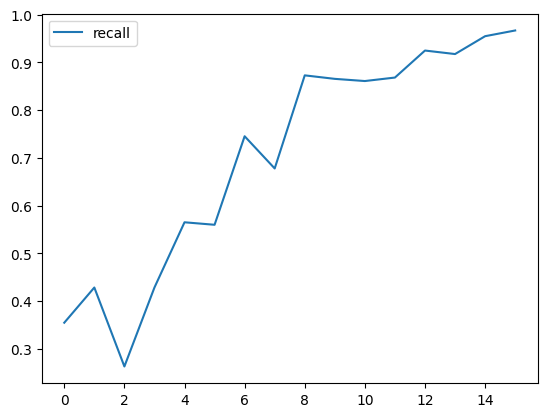

In [66]:
training_eval_df = df.from_records(results)
plot_2 = training_eval_df.plot(kind='line', y='recall')

In [4]:
# Start of Task 2
import requests
import json

url = "http://localhost:11434/api/generate"
headers = {
    "Content-Type": "application/json"
}
model_deepseek = "deepseek-r1:7b"
model_llama = "llama3.2:1b"
data = {
    "model": model_llama,
    "prompt": "",
    "stream": False
}

explanations_df = df[(df['FailingMethod'] == 'HIT01_8') & (df['TP'] == 1)]
ground_truth = 'The specification states, that the method "DateTimeZone()" accepts a minutes offset value in the range of -59 to 59 inlcusive. The method checks if this value, stored as "minutesOffset", is within these bounds on line 279, but incorrectly throws an "IllegalArgumentException" for any minutes offset less than zero instead of less than -59. To fix the issue and satisfy the specification, the conditional on line 279 should check for "minutesOffset < -59" instead.'

In [12]:
# Start of loop here

prompt = "### Task:\nYour are a professional software developer. Please consolidate the following failure explanations into a single explanation, that contains all the information required to understand and fix the bug. The explanation should be succinct and without redundant information.\n\n### Output:\nReturn a JSON with a single field consolidated_explanation that contains the generated explanation.\n\n### Input:\nHere is a list of explanations that should be consolidated:\n\n"

prompt_task = "### Task:\nYou are a professional software developer. You are given a number of explanations of a software failure. Please consolidate the following failure explanations into a single explanation, that contains all the information required to understand and fix the bug. The explanation should be succinct and without redundant information.\n\n"

prompt_task_2 = "###Task:\nYou are a professional software developer. You are given a number of explanations describing the root of cause and possible fix to a software failure. Based on the given explanations, write a single explanation that contains all the information required to understand and fix the bug. The explanation should be succinct and without redundant information"

prompt_input = "### Input:\n\nHere are the failure explanations to consolidate:\n\n"

prompt_input_2 = "### Input:\n\nHere are the failure explanations:\n\n"

prompt_output = "### Output:\n Format your response in valid JSON format. Use the field 'consolidated_explanation' for your generated explanation. Output an empty string in case no consolidated explanation could be generated. Use the field 'notes' for any other notes or remarks.\n\n"

prompt_output_2 = "### Output:\n Format your response in valid JSON format. Use the field 'failure_explanation' for your generated explanation. Output an empty string in case no sufficient explanation could be generated. Use the field 'notes' for any other notes or remarks.\n\n"

explanation_list = ["'''\n" + explanation + "\n'''\n\n" for explanation in explanations_df['Answer.explanation'].to_list()]

task2_runs = 31
responses = []

for i in tqdm.tqdm(range(task2_runs)):
    if i >= len(explanation_list):
        break
    inputs = ''.join(explanation_list[0:i])

    temp_prompt_2 = prompt_task_2 + prompt_input_2 + inputs + prompt_output_2

    temp_prompt = prompt_task + prompt_input + inputs + prompt_output
    data["prompt"] = temp_prompt_2

    response = requests.post(url, headers=headers, data=json.dumps(data))

    if (response.status_code == 200):
        responses.append(json.loads(response.text)["response"])
    else:
        # print("Error: ", response.status_code, response.text)
        pass

100%|██████████| 31/31 [05:16<00:00, 10.21s/it]


In [21]:
print(responses[-1])

```json
{
  "failure_explanation": "The variable `minutesOffset` is checked incorrectly by the IF statement on line 279. It should be `< -59` to correctly handle negative input. This causes an `IllegalArgumentException` to be thrown when `minutesOffset` is less than 0.",
  "notes": "This issue is with the way the `DateTimeZone.forOffsetHoursMinutes()` method handles negative hours and minutes when used as a parameter for the function. It incorrectly throws an exception when both hours and minutes are negative, instead of correctly handling them."
}
```


In [ ]:
for item in responses:
    print(item)

In [74]:
from rouge_metric import PyRouge
from bleurt import score
import textstat

def calculateFKScore(candidate) -> float:
        return textstat.flesch_reading_ease(candidate)

def calculateRougeScore(reference, candidate) -> dict:
        rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, skip_gap=4)
        rouge_scores = rouge.evaluate([candidate], [reference])
        return rouge_scores

def calculateBleurtScore(references, candidates) -> list:
        scorer = score.LengthBatchingBleurtScorer(checkpoint='BLEURT-20')
        bleurt_scores = scorer.score(references=references, candidates=candidates)
        # assert isinstance(bleurt_scores, list) and len(bleurt_scores) == 1
        return bleurt_scores


In [48]:
for i in range(len(g_e)):
    try:
        json.loads(g_e[i])
    except:
        print(i)
        break

4


In [56]:
generated_explanations = [re.search('\{[.\s\S]*\}', expl) for expl in responses]
# generated_explanations = [e.group() if e is not None else None for e in generated_explanations]
generated_explanations = [e.group() for e in generated_explanations if e is not None]
ge = []
for e in generated_explanations:
    try:
        ge.append(json.loads(e))
    except:
        ge.append(None)
generated_explanations = [next(iter(e.values())) if e is not None else '' for e in ge]

In [66]:
rouge_score = []
for e in generated_explanations:
    if e != '':
        rouge_score.append(calculateRougeScore(ground_truth, e))
        # bleurt_score.append(calculateBleurtScore(ground_truth, e))
    else:
        rouge_score.append({})
        # bleurt_score.append([])

In [64]:
ground_truth_list = []
bleurt_score = []
for i in range(len(generated_explanations)):
    ground_truth_list.append(ground_truth)

bleurt_score = calculateBleurtScore(ground_truth_list, generated_explanations)

INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:Average batch sequence length: 190.0


INFO:tensorflow:Average batch sequence length: 190.0


In [68]:
bleurt_score

[0.3249141573905945,
 0.4257364869117737,
 0.43702423572540283,
 0.40799134969711304,
 0.067359060049057,
 0.4318205714225769,
 0.41227179765701294,
 0.33928704261779785,
 0.4399755001068115,
 0.46148884296417236,
 0.40926170349121094,
 0.47955751419067383,
 0.44182026386260986,
 0.41406530141830444,
 0.41227227449417114,
 0.42311233282089233,
 0.44158077239990234,
 0.41530275344848633,
 0.4525569677352905,
 0.067359060049057,
 0.14106303453445435,
 0.4146652817726135,
 0.4155564308166504,
 0.4645983576774597,
 0.4427146315574646,
 0.067359060049057,
 0.45555955171585083,
 0.4833563566207886]

In [92]:
generated_explanations[9]

'The variable `minutesOffset` is checked incorrectly by the IF statement on line 279. Any negative value for `minutesOffset` will throw an exception; while the documentation states that `minutesOffset` can be negative in some cases. This error occurs when the code tests if `minutesOffset` < 0, which it should instead check for `minutesOffset < -59`. Also noted is that versions before 2.3 had to set minutesOffset to 0 or positive.'

In [75]:
readability_score = []

for e in tqdm.tqdm(generated_explanations):
    if e != '':
          readability_score.append(calculateFKScore(e))
    else:
        readability_score.append(-1.0)


100%|██████████| 28/28 [00:00<00:00, 167532.83it/s]


In [78]:
readability_score

[-79.76,
 64.71,
 64.71,
 58.89,
 -1.0,
 37.6,
 28.84,
 46.1,
 60.14,
 49.41,
 77.06,
 52.19,
 64.54,
 30.2,
 28.84,
 49.15,
 47.62,
 58.62,
 40.04,
 -1.0,
 -132.59,
 46.1,
 54.73,
 50.67,
 50.16,
 -1.0,
 42.41,
 51.14]

In [91]:
gt_readability = calculateFKScore(ground_truth)
gt_readability

47.12

<function matplotlib.pyplot.show(close=None, block=None)>

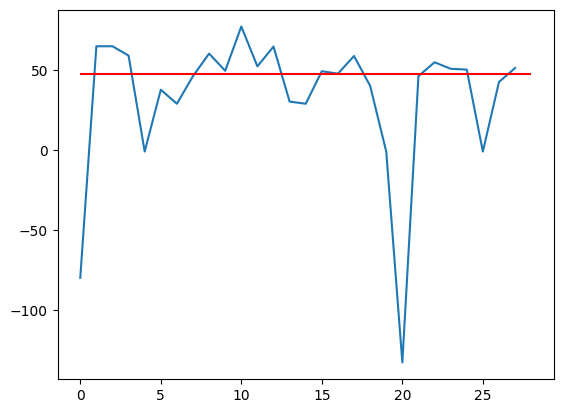

In [88]:
import matplotlib.pyplot as plt

xs = [x for x in range(len(readability_score))]
plt.plot(xs, readability_score)
plt.hlines(y=gt_readability, xmin=0, xmax=len(readability_score), color='r')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

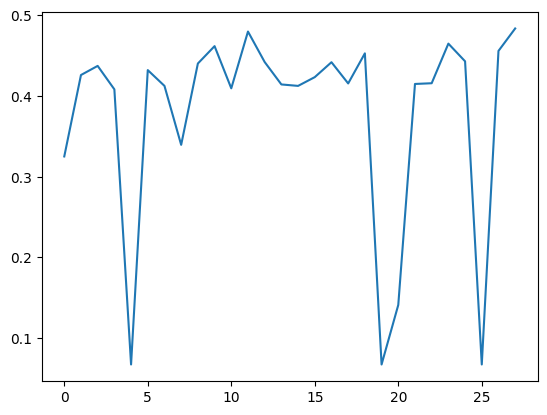

In [81]:
plt.plot(xs, bleurt_score)
plt.show